# **Install Libraries** **- Llama 3.1 - 8B Instruct - (QA)**

In [1]:
!pip install transformers accelerate bitsandbytes datasets
#!pip install -q -U evaluate
!pip install -q -U tokenizers
!pip install nltk
!pip install transformers torch accelerate
!pip install git+https://github.com/huggingface/trl.git@main

  Cloning https://github.com/huggingface/trl.git (to revision main) to /tmp/pip-req-build-9z40yrpl
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-9z40yrpl
  Resolved https://github.com/huggingface/trl.git to commit 072d7dd5a6e43424aee65d7c1ab8b74d672399f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import Packages

In [1]:

%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

import torch
import pandas as pd
import os
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    set_seed
)
import re
import pandas as pd

from peft import get_peft_model, LoraConfig, TaskType,prepare_model_for_kbit_training
from trl import SFTTrainer

from transformers import LlamaTokenizer, LlamaForCausalLM, Trainer
from datasets import load_dataset



env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [2]:
!pip install -q transformers huggingface_hub

# Login (you'll be prompted to paste your token)
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add t

# Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

# Folder where all CSV files are located
folder_path = "/content/drive/My Drive/Colab Notebooks/DS-266/Data/qa-data"


# Get all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Read and combine all CSVs
qa_combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in csv_files])

# Function to remove contents within << >>
def remove_double_angle_brackets(text):
    return re.sub(r"<<.*?>>", "", text)

# Apply to a specific column (e.g., 'answer')
qa_combined_df["answer"] = qa_combined_df["answer"].apply(remove_double_angle_brackets)

qa_combined_df = qa_combined_df.dropna(subset=["question", "answer"])



In [6]:
qa_combined_df.describe()

,question,answer
count,8792,8792
unique,8792,8792
top,Henry and 3 of his friends order 7 pizzas for ...,There are 7*8=56 slices in total.\nThere are 1...
freq,1,1


In [5]:
qa_combined_df['question'].value_counts().head()


,count
question,
"Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry and his friends want to share the pizzas equally, how many slices can each of them have?",1
"Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",1
"Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?",1
"Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",1
"Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?",1


In [8]:
# Step 1: Sort by answer length (keep the longer one, assuming it's more complete)
qa_combined_df['answer_length'] = qa_combined_df['answer'].str.len()

# Step 2: Drop duplicates on 'question', keeping the row with the longest answer
qa_unique = qa_combined_df.sort_values('answer_length', ascending=True).drop_duplicates(subset='question', keep='first')

# Step 3: Drop the helper column
qa_unique = qa_unique.drop(columns=['answer_length'])

In [9]:
qa_unique.describe()

,question,answer
count,8792,8792
unique,8792,8792
top,Peggy is moving and is looking to get rid of h...,Sammy is offering to take the whole collection...
freq,1,1


In [10]:
qa_unique[:5]

,question,answer
4144,You have 32$ to spend on groceries. You buy a...,32-3=29\n29-2=27\n27(1/3)=9\n27-9=18$\n#### 18
5516,A cat has nine lives. A dog has 3 less lives ...,Dog:9-3=6 lives\nMouse:6+7=13 lives\n#### 13
3794,Kendra made 4 more than five times as many dec...,Kendra made 4+5*8=44.\nSue made 44/2=22.\n#### 22
4519,Mari made 4 more than five times as many decor...,Kendra made 2*6=12.\nMari made 4+5*12=64.\n###...
695,There are 50 deer in a field. 50 percent of t...,Bucks:50(.50)=25\n8 Points:25(.20)=5 bucks\n##...


In [11]:

# Function to split steps and final answer
def extract_steps_and_answer(solution):
    if pd.isna(solution):
        return pd.Series(["", ""])
    if '####' in solution:
        steps, final_answer = solution.split('####')
        return pd.Series([steps.strip(), final_answer.strip()])
    else:
        return pd.Series([solution.strip(), ""])

# Apply to DataFrame
qa_unique[['steps', 'final_answer']] = qa_unique['answer'].apply(extract_steps_and_answer)

qa_final = qa_unique[['question', 'steps', 'final_answer']]

# Preview the result
print(qa_unique[['question', 'steps', 'final_answer']].head())


                                               question  \
4144  You have 32$ to spend on groceries.  You buy a...   
5516  A cat has nine lives.  A dog has 3 less lives ...   
3794  Kendra made 4 more than five times as many dec...   
4519  Mari made 4 more than five times as many decor...   
695   There are 50 deer in a field.  50 percent of t...   

                                           steps final_answer  
4144       32-3=29\n29-2=27\n27(1/3)=9\n27-9=18$           18  
5516         Dog:9-3=6 lives\nMouse:6+7=13 lives           13  
3794    Kendra made 4+5*8=44.\nSue made 44/2=22.           22  
4519   Kendra made 2*6=12.\nMari made 4+5*12=64.           64  
695   Bucks:50(.50)=25\n8 Points:25(.20)=5 bucks            5  


In [12]:
qa_final['question_length'] = qa_final['question'].str.len()

# Sort the DataFrame by question length (ascending or descending)
qa_final_sorted = qa_final.sort_values(by='question_length', ascending=True).reset_index(drop=True)

qa_final_sorted = qa_final_sorted.drop(columns=['question_length'])

# View the result
print(qa_final_sorted.head())  #

                                            question  \
0         What is fifteen more than a quarter of 48?   
1  Twice Angie's age, plus 4, is 20. How old is A...   
2  Steve is 5'6".  He grows 6 inches.  How tall i...   
3  If 12 bags of oranges weigh 24 pounds, how muc...   
4  A roll of 25 m wire weighs 5 kg. How much does...   

                                               steps final_answer  
0  A quarter of 48 is 48/4=12.\nThe number is 12+...           27  
1    Twice Angie's age is 20-4=16.\nAngie is 16/2=8.            8  
2  He is 5*12+6=66 inches tall before the growth ...           72  
3  Each bag of oranges weighs 24 pounds / 12 = 2 ...           16  
4  We know that the 75 m roll is three times bigg...           15  


In [13]:
qa_final = qa_final_sorted[:1000]


In [14]:
# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(qa_final.drop(columns=["index"], errors="ignore").reset_index(drop=True))


In [15]:
dataset

Dataset({
    features: ['question', 'steps', 'final_answer'],
    num_rows: 1000
})

## Split the Dataset


In [16]:
shuffled = dataset.shuffle(seed=42)

#Due to compute limitations, dividing the dataset into smaller subsets.
train_small = shuffled.select(range(0, 100))
train_medium = shuffled.select(range(100, 300))
train_large = shuffled.select(range(300, 600))
validation_set = shuffled.select(range(700, 750))
test_set = shuffled.select(range(750, 950))


In [17]:

print(f"Train: {len(train_small)}, Validation: {len(train_large)}, Test: {len(validation_set)}")


Train: 100, Validation: 300, Test: 50


# Model - Llama-3.1


In [19]:

model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct" # finetuned model
#save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b"  #  directory in Colab


tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)
# tokenizer.save_pretrained(save_path)


In [ ]:
# Load Saved Base Model
base_model = AutoModelForCausalLM.from_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model/", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model/")

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
tokenizer.pad_token = tokenizer.eos_token

In [21]:
# Tokenize the Question, Steps and Final Answer
def tokenize_for_only_answer(example, tokenizer, max_total_length=512):
    question_text = example['question']
    steps = example['steps']
    final_answer_value = example['final_answer']

    # 1. Construct the full prompt text for this specific prompt
    full_prompt_text = (
    f"You are a helpful math teacher. Solve the problem by listing only simple equations for each step. DO NOT include detailed explanations or alternative approaches. Your final answer should be a single number on a new line, prefixed with '#### '.\n\n"

    f"Example 1:\n"
    f"Problem: If you have 10 apples and eat 2, then buy 5 more, how many apples do you have?\n"
    f"Steps:\n10 - 2 = 8\n8 + 5 = 13\n####13\n\n"

    f"Problem: {question_text}\nSteps:\n"
)

    # 2. Combine with the target final answer
    full_sequence_text = full_prompt_text + str(final_answer_value) + tokenizer.eos_token

    # 3. Tokenize the entire sequence
    tokenized_output = tokenizer(
        full_sequence_text,
        truncation=True,
        max_length=max_total_length,
        padding="max_length",
        return_tensors="pt"
    )

    input_ids = tokenized_output["input_ids"].squeeze(0)
    attention_mask = tokenized_output["attention_mask"].squeeze(0)

    # 4. Create labels: Mask the prompt part
    prompt_tokenized_for_length = tokenizer(
        full_prompt_text,
        truncation=True,
        max_length=max_total_length,
        padding=False,
        return_tensors="pt" # This returns [1, length]
    )["input_ids"]

    prompt_length_in_tokens = prompt_tokenized_for_length.shape[1] # Correctly gets length from [1, length]

    labels = input_ids.clone()

    labels[:prompt_length_in_tokens] = -100

    labels = labels.squeeze(0) # This squeeze is redundant if labels is already 1D, but harmless

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [22]:


# For training the minimal_steps_teacher model:
train_1= train_small.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',  'steps', 'final_answer'] # Remove original text columns
)
train_2 = train_medium.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',  'steps', 'final_answer']
)


# train_3 = train_large.map(
#     lambda x: tokenize_for_only_answer(x, tokenizer),
#     remove_columns=['question',  'steps', 'final_answer'])

valid = validation_set.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',   'final_answer']
)
test = test_set.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',    'final_answer']
)

#print(f"Tokenized: {len(train_1)} train_1, {len(train_2)} train_2, {len(valid)} valid, {len(test)} test.")





Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [23]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"  # or "cpu" if you want to force CPU
)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

# # # Save both to disk
# base_model.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model")
# print("Base model saved successfully!")


Base model saved successfully!


In [ ]:
# tokenizer.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model")
# print("Tokenizer saved successfully")

Tokenizer saved successfully


In [23]:
# Validation
# for item in test_set:
#     print(f"Q: {item['question']}\nSteps:{item['steps']}\nExpected: {item['final_answer']}\n")
pad_token_id=tokenizer.eos_token_id,
eos_token_id=tokenizer.eos_token_id

In [24]:

def extract_answer(output, prompt_type):
    if prompt_type == "single_shot":
        numbers = re.findall(r'(-?\d+\.?\d+)', output) # Find any number (int or float, positive/negative)
        if numbers:
            try:
                val = numbers[0] # Take the very first number found
                return float(val) if '.' in val else int(val)
            except ValueError:
                return None
        return None

    elif prompt_type == "few_shot_math_only_answer":
        # ... (your current, working logic for minimal_steps_teacher)
        matches = re.findall(r'=\s*(-?\d+\.?\d*)', output)
        #re.search(r"Final Answer:\s*(-?\d+(?:\.\d+)?)", text)
        if matches:
            try:
                val = matches[-1] # Take the LAST matched number after '####'
                return float(val) if '.' in val else int(val)
            except ValueError:
                return None
        return None

    # Fallback for unexpected prompt types.
    print(f"Warning: Unknown prompt_type '{prompt_type}' in extract_answer. No specific parsing logic.")
    return None




In [25]:
from tqdm import tqdm


prompt_templates = {
  "single_shot": {
    "prompt_fn": lambda q: f"""You are a helpful math teacher. Solve the following problem using simple math equations. Do not write explanations or assumptions. Just write one equation per step, and give the final answer on a new line. End with: Answer: <number>\n\n

Problem: {q}
Steps:
""",
    "max_tokens": 314,
    "temperature": 0.7,
    "top_p": 0.9
}
    ,
"few_shot_math_only_answer": {
    "prompt_fn": lambda q: f"""You are a helpful math teacher. Solve the problem by listing only simple equations for each step. DO NOT include detailed explanations or alternative approaches. Your final answer should be a single number on a new line, prefixed with '#### '.

Example 1:
Problem: If you have 10 apples and eat 2, then buy 5 more, how many apples do you have?
Steps:
10 - 2 = 8
8 + 5 = 13
#### 13

Example 2:
Problem: You have 32$ to spend on groceries. You buy a loaf of bread for 3$, a candy bar for 2$, and 1/3 of what's left on a Turkey. How much money do you have left?
Steps:
32 - 3 = 29
29 - 2 = 27
27 * (1/3) = 9
27 - 9 = 18
#### 18

Problem: {q}
Steps:
""",
    "max_tokens": 512,
    "temperature": 0.7,
    "top_p": 0.9
}
}



# Define shared config
shared_config = {
    "max_tokens": 15,
    "temperature": 0.3,
    "top_p": 0.9
}



def evaluate_model(prompt_name, prompt_config, dataset, model, tokenizer, max_samples=None):

    correct = 0
    records = []

    prompt_fn = prompt_config["prompt_fn"]
    max_tokens = prompt_config.get("max_tokens", 256)
    temperature = prompt_config.get("temperature", 0.7)
    top_p = prompt_config.get("top_p", 0.9)

    iterator = dataset if max_samples is None else dataset[:max_samples]

    for example in tqdm(iterator, desc=f"Evaluating {prompt_name}"):
        question = example["question"]
        expected_answer = example["final_answer"]

        prompt = prompt_fn(question)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_tokens,
                pad_token_id=tokenizer.eos_token_id,
                temperature=temperature,
                top_p=top_p,
                do_sample=True,
                num_return_sequences=1
            )

        decoded_full = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_text = decoded_full[len(prompt):].strip()

        pred = extract_answer(generated_text, prompt_name)

        is_correct = False
        if pred is not None:
            try:
                if abs(float(pred) - float(expected_answer)) < 1e-6:
                    is_correct = True
            except (ValueError, TypeError):
                pass

        if is_correct:
            correct += 1

        records.append({
            "question": question,
            "expected_answer": expected_answer,
            "predicted_answer": pred,
            "decoded_full": decoded_full,
            "full_output": generated_text,
            "is_correct": is_correct,
            "prompt": prompt_name
        })

    accuracy = correct / len(iterator) if len(iterator) > 0 else 0
    results_df = pd.DataFrame(records)
    return accuracy, results_df


In [ ]:
acc_dict = {}
results_dict = {}

for prompt_name in ["single_shot", "few_shot_math_only_answer"]:
    prompt_config = {
        "prompt_fn": prompt_templates[prompt_name]["prompt_fn"],
        "max_tokens": shared_config["max_tokens"],
        "temperature": shared_config["temperature"],
        "top_p": shared_config["top_p"]
    }

    print(f"\n{'='*10} Testing Prompt: {prompt_name} {'='*10}")
    accuracy, results_df = evaluate_model(prompt_name, prompt_config, test_set.select(range(200)), base_model, tokenizer)
    acc_dict[prompt_name] = accuracy * 100
    results_dict[prompt_name] = results_df
    print(f"Accuracy for '{prompt_name}': {accuracy * 100:.2f}%")
    print("=" * 50)




========== Testing Prompt: single_shot ==========


Evaluating single_shot: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Accuracy for 'single_shot': 0.50%

========== Testing Prompt: few_shot_math_only_answer ==========


Evaluating few_shot_math_only_answer: 100%|██████████| 200/200 [02:42<00:00,  1.23it/s]

Accuracy for 'few_shot_math_only_answer': 30.50%


# Error Analysis

In [ ]:

# Show all columns and rows without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
wrong_df_single_shot = results_dict["single_shot"]

In [ ]:
# save_result_dict to drive


save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/multiple_step_result_before_training_single_shot.csv"  #  directory in Colab

wrong_df_single_shot.to_csv(save_path, index=False)
wrong_df_single_shot[:3]

,question,expected_answer,predicted_answer,decoded_full,full_output,is_correct,prompt
0,"Rose bought a plant with a 10% discount. If the price is $10, how much did Rose pay after the discount?",9,10.0,"You are a helpful math teacher. Solve the following problem using simple math equations. Do not write explanations or assumptions. Just write one equation per step, and give the final answer on a new line. End with: Answer: <number>\n\n\n\nProblem: Rose bought a plant with a 10% discount. If the price is $10, how much did Rose pay after the discount?\nSteps:\n1. 10% of 10 = 1\n2.",1. 10% of 10 = 1\n2.,False,single_shot
1,"Tire repair for each tire costs $7, plus another 50 cents for sales tax. If Juan needs all 4 tires repaired, how much is the final cost?",30,0.5,"You are a helpful math teacher. Solve the following problem using simple math equations. Do not write explanations or assumptions. Just write one equation per step, and give the final answer on a new line. End with: Answer: <number>\n\n\n\nProblem: Tire repair for each tire costs $7, plus another 50 cents for sales tax. If Juan needs all 4 tires repaired, how much is the final cost?\nSteps:\n1. 7 + 0.5 = \n2. 4",1. 7 + 0.5 = \n2. 4,False,single_shot
2,Jean has three times as much money as Jane. They have a combined total of $76. How much money does Jean have?,57,NaN,"You are a helpful math teacher. Solve the following problem using simple math equations. Do not write explanations or assumptions. Just write one equation per step, and give the final answer on a new line. End with: Answer: <number>\n\n\n\nProblem: Jean has three times as much money as Jane. They have a combined total of $76. How much money does Jean have?\nSteps:\n1. Let J = Jean's money, and let j = Jane's","1. Let J = Jean's money, and let j = Jane's",False,single_shot


In [ ]:
wrong_df_few_shot = results_dict["few_shot_math_only_answer"]
save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/multiple_step_result_before_training_few_shot.csv"  #  directory in Colab
wrong_df_few_shot.to_csv(save_path, index=False)
wrong_df_few_shot[:3]


,question,expected_answer,predicted_answer,decoded_full,full_output,is_correct,prompt
0,"Rose bought a plant with a 10% discount. If the price is $10, how much did Rose pay after the discount?",9,9.0,"You are a helpful math teacher. Solve the problem by listing only simple equations for each step. DO NOT include detailed explanations or alternative approaches. Your final answer should be a single number on a new line, prefixed with '#### '.\n\nExample 1:\nProblem: If you have 10 apples and eat 2, then buy 5 more, how many apples do you have?\nSteps:\n10 - 2 = 8\n8 + 5 = 13\n#### 13\n\nExample 2:\nProblem: You have 32$ to spend on groceries. You buy a loaf of bread for 3$, a candy bar for 2$, and 1/3 of what's left on a Turkey. How much money do you have left?\nSteps:\n32 - 3 = 29\n29 - 2 = 27\n27 * (1/3) = 9\n27 - 9 = 18\n#### 18\n\nProblem: Rose bought a plant with a 10% discount. If the price is $10, how much did Rose pay after the discount?\nSteps:\n10 * (1 - 0.1) = 9\n####",10 * (1 - 0.1) = 9\n####,True,few_shot_math_only_answer
1,"Tire repair for each tire costs $7, plus another 50 cents for sales tax. If Juan needs all 4 tires repaired, how much is the final cost?",30,28.0,"You are a helpful math teacher. Solve the problem by listing only simple equations for each step. DO NOT include detailed explanations or alternative approaches. Your final answer should be a single number on a new line, prefixed with '#### '.\n\nExample 1:\nProblem: If you have 10 apples and eat 2, then buy 5 more, how many apples do you have?\nSteps:\n10 - 2 = 8\n8 + 5 = 13\n#### 13\n\nExample 2:\nProblem: You have 32$ to spend on groceries. You buy a loaf of bread for 3$, a candy bar for 2$, and 1/3 of what's left on a Turkey. How much money do you have left?\nSteps:\n32 - 3 = 29\n29 - 2 = 27\n27 * (1/3) = 9\n27 - 9 = 18\n#### 18\n\nProblem: Tire repair for each tire costs $7, plus another 50 cents for sales tax. If Juan needs all 4 tires repaired, how much is the final cost?\nSteps:\n7 * 4 = 28\n28 * (1/2)",7 * 4 = 28\n28 * (1/2),False,few_shot_math_only_answer
2,Jean has three times as much money as Jane. They have a combined total of $76. How much money does Jean have?,57,76.0,"You are a helpful math teacher. Solve the problem by listing only simple equations for each step. DO NOT include detailed explanations or alternative approaches. Your final answer should be a single number on a new line, prefixed with '#### '.\n\nExample 1:\nProblem: If you have 10 apples and eat 2, then buy 5 more, how many apples do you have?\nSteps:\n10 - 2 = 8\n8 + 5 = 13\n#### 13\n\nExample 2:\nProblem: You have 32$ to spend on groceries. You buy a loaf of bread for 3$, a candy bar for 2$, and 1/3 of what's left on a Turkey. How much money do you have left?\nSteps:\n32 - 3 = 29\n29 - 2 = 27\n27 * (1/3) = 9\n27 - 9 = 18\n#### 18\n\nProblem: Jean has three times as much money as Jane. They have a combined total of $76. How much money does Jean have?\nSteps:\nJ + 3J = 76\n4J = 76\n",J + 3J = 76\n4J = 76,False,few_shot_math_only_answer


{'single_shot': 0.5, 'few_shot_math_only_answer': 30.5}


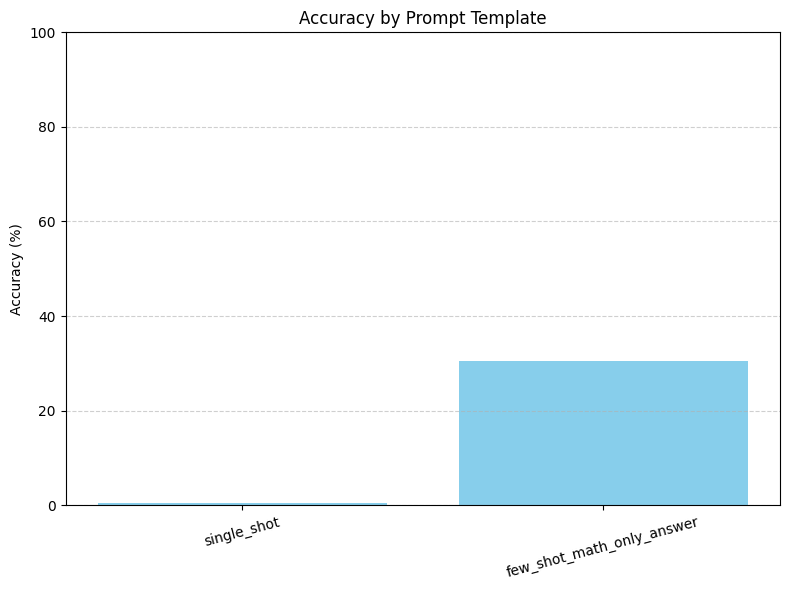

In [ ]:
import matplotlib.pyplot as plt


# Extracting prompt names and accuracies
prompt_names = list(acc_dict.keys())
accuracies = list(acc_dict.values())

# Print dictionary for reference
print(acc_dict)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(prompt_names, accuracies, color='skyblue')


plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Prompt Template")
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



# Model Training

In [37]:
# train Model on 2k datasets
!pip install rouge_score

In [38]:
# Extract Answer from Model full output

def extract_numerical_answer(text: str):
    # Try #### N, or "Answer: N", then fallback to last number
    m = re.search(r"(?:####\s*|Answer:\s*)(-?\d+(?:\.\d+)?)\s*$", text.strip())
    if m:
        return m.group(1)
    nums = re.findall(r"-?\d+(?:\.\d+)?", text)
    return nums[-1] if nums else None

def _to_list(x):
    return x.tolist() if isinstance(x, np.ndarray) else x

def _replace_ignore_idx(labels, pad_id):
    out = []
    for seq in labels:
        seq = list(seq)
        out.append([tok if tok != -100 else pad_id for tok in seq])
    return out

# Evaluate Test Data
def compute_metrics(eval_pred):
    if isinstance(eval_pred, tuple):
        predictions, labels = eval_pred
    else:
        predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # If predictions are logits (batch, seq_len, vocab), convert to token ids
    if isinstance(predictions, np.ndarray) and predictions.ndim == 3:
        predictions = predictions.argmax(-1)

    # Convert to python lists for safer processing
    predictions = _to_list(predictions)
    labels      = _to_list(labels)

    # Replace -100 in labels for decoding
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
    labels = _replace_ignore_idx(labels, pad_id)

    # Decode
    decoded_preds  = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels,      skip_special_tokens=True)

    print('decoded_preds',decoded_preds)
    print('--------------')
    print('decoded_labels', decoded_labels)

    # ROUGE-L
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    rouge_l_scores = []
    correct_num = 0
    total_num   = 0

    for pred, ref in zip(decoded_preds, decoded_labels):
        pred = pred.strip()
        ref  = ref.strip()

        # ROUGE-L (guard empty)
        if not pred and not ref:
            rouge_l_scores.append(1.0)
        elif not pred or not ref:
            rouge_l_scores.append(0.0)
        else:
            rouge = scorer.score(ref, pred)
            rouge_l_scores.append(rouge['rougeL'].fmeasure)

        # numeric accuracy
        pnum = extract_numerical_answer(pred)
        rnum = extract_numerical_answer(ref)
        if pnum is not None and rnum is not None:
            total_num += 1
            try:
                if float(pnum) == float(rnum):
                    correct_num += 1
            except ValueError:
                pass

    rougeL = float(np.mean(rouge_l_scores)) if rouge_l_scores else 0.0
    num_acc = (100.0 * correct_num / total_num) if total_num > 0 else 0.0
    return {"rougeL": rougeL, "numerical_accuracy": num_acc}


In [26]:
import torch, gc


# Clear cache
gc.collect()
torch.cuda.empty_cache()

In [28]:
#
import os


# Optional: Reduces memory fragmentation for large models
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear GPU memory
gc.collect()
torch.cuda.empty_cache()

# # Model and quant config
# model_name = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model"
# tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model/")
# model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"


bnb_config = BitsAndBytesConfig(

    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"

)


base_model_4bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
    token = token,
    trust_remote_code=True

)


# Enable gradient checkpointing BEFORE LoRA or preparation
base_model_4bit.gradient_checkpointing_enable()
base_model_4bit.enable_input_require_grads()

# Enable Low Memory
def prepare_model_for_kbit_training_lowmem(model):
    for param in model.parameters():
        param.requires_grad = False
        # Avoid converting to float32 to prevent OOM
        if hasattr(param, "dtype") and param.__class__.__name__ != "Params4bit":
            continue
    model.gradient_checkpointing_enable()
    model.enable_input_require_grads()
    return model

# Use patched version to avoid OOM
base_model_4bit = prepare_model_for_kbit_training_lowmem(base_model_4bit)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
#LoRA (Low-Rank Adaptation)  - Fine tuning the LLM
#QLora - Change r and alpha
# Look fine tuning notebook with limited RAM
# Model -> test data - measure

lora_config = LoraConfig(
    r=4, # LoRA rank
    lora_alpha=16, # Scaling factor for the LoRA weights
    lora_dropout=0.0, #Dropout rate applied to LoRA layers during training
    bias="none",
    task_type="CAUSAL_LM", # CAUSAL_LM - for decoder only model
    target_modules=["q_proj", "v_proj"]
)


model = get_peft_model(base_model_4bit, lora_config)
model.print_trainable_parameters()


trainable params: 1,703,936 || all params: 8,031,965,184 || trainable%: 0.0212


In [31]:
# Step 1 Training Arguments
training_args = TrainingArguments(
    output_dir="./llama3-qlora-out",
    optim="paged_adamw_8bit",
    max_grad_norm=0.3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    logging_steps=1,
    logging_strategy="steps",

    save_strategy="epoch",
    num_train_epochs=3,
    learning_rate=5e-5,
    bf16=True,
    gradient_checkpointing=True,
    report_to="none",
    eval_strategy="epoch"

)


In [32]:

os.environ["WANDB_DISABLED"] = "true"          # disables everything
os.environ["WANDB_MODE"] = "disabled"          # no offline/online/anonymous


In [33]:

# Clear cache
gc.collect()
torch.cuda.empty_cache()

# Optional: Reduces memory fragmentation for large models
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


# --- Clear GPU memory IMMEDIATELY BEFORE trainer.train() ---
# This is the most crucial spot to ensure maximum free memory for the training loop.
print("\nClearing GPU memory just before trainer.train()...")
gc.collect()
torch.cuda.empty_cache()
print(f"GPU memory status before train: {torch.cuda.memory_allocated() / (1024**3):.2f} GB allocated, {torch.cuda.memory_reserved() / (1024**3):.2f} GB reserved")




Clearing GPU memory just before trainer.train()...
GPU memory status before train: 35.23 GB allocated, 35.31 GB reserved


In [34]:

# Step 2: Set up generation kwargs separately for SFTTrainer
generation_config = {
    "max_new_tokens": 64,
    "do_sample": False,
    "num_beams": 1,
}

# Step 3: Instantiate the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_1,
    eval_dataset=valid,
peft_config=lora_config,
    compute_metrics=compute_metrics,


)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'meta-llama/Meta-Llama-3.1-8B-Instruct' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rougel,Numerical Accuracy
1,No log,1.018633,0.002828,0.000000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=7, training_loss=2.286840166364397, metrics={'train_runtime': 60.114, 'train_samples_per_second': 1.664, 'train_steps_per_second': 0.116, 'total_flos': 2306036308377600.0, 'train_loss': 2.286840166364397})

In [ ]:
trainer.state.log_history  # Loss Metrics


[{'eval_loss': 1.0186326503753662,
  'eval_rougeL': 0.002827992187540225,
  'eval_numerical_accuracy': 0.0,
  'eval_runtime': 13.8191,
  'eval_samples_per_second': 3.618,
  'eval_steps_per_second': 0.507,
  'eval_num_tokens': 51200.0,
  'eval_mean_token_accuracy': 0.8608971067837307,
  'epoch': 1.0,
  'step': 7},
 {'train_runtime': 60.114,
  'train_samples_per_second': 1.664,
  'train_steps_per_second': 0.116,
  'total_flos': 2306036308377600.0,
  'train_loss': 2.286840166364397,
  'epoch': 1.0,
  'step': 7}]

In [ ]:

trainer.model.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_100_model")
tokenizer.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_100_model")



('/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_100_model/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_100_model/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_100_model/chat_template.jinja',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_100_model/tokenizer.json')

In [45]:
def _to_number(num_str: str):
    s = num_str.replace(",", "").replace("$", "").strip()
    try:
        x = float(s)
        return int(x) if x.is_integer() else x
    except ValueError:
        return None

def extract_answer(output, prompt_type):
    if prompt_type == "single_shot":
        # Find the number immediately following the last occurrence of "Answer:"
        # Handles cases like "Answer: 9", "Answer: $9", "Answer: 9.0"
        matches = re.findall(r"Answer:\s*([$]?\s*-?\d+(?:\.\d+)?)", output, flags=re.IGNORECASE)
        if matches:
            return _to_number(matches[-1])  # take the last "Answer:" if multiple
        # Fallback: look for a line starting with Answer and then a number
        m = re.search(r"^[ \t]*Answer:\s*([$]?\s*-?\d+(?:\.\d+)?)", output, flags=re.IGNORECASE | re.MULTILINE)
        if m:
            return _to_number(m.group(1))
        return None

    elif prompt_type == "few_shot_math_only_answer":
        # ... (your current, working logic for minimal_steps_teacher)
        matches = re.findall(r'=\s*(-?\d+\.?\d*)', output)
        #re.search(r"Final Answer:\s*(-?\d+(?:\.\d+)?)", text)
        if matches:
            try:
                val = matches[-1] # Take the LAST matched number after '####'
                return float(val) if '.' in val else int(val)
            except ValueError:
                return None
        return None

    # Fallback for unexpected prompt types.
    print(f"Warning: Unknown prompt_type '{prompt_type}' in extract_answer. No specific parsing logic.")
    return None


In [43]:

from tqdm import tqdm


prompt_templates = {
  "single_shot": {
    "prompt_fn": lambda q: f""" "You are a helpful math teacher.\n
        Rules:\n
        - Write one simple numerical equation per line.\n
        - Use only digits, +, -, *, /, (, ), =.\n
        - Do NOT write any words, labels, or explanations.\n
        - End with: Answer: <number>\n\n

Problem: {q}
Steps:\n
"""
}
    ,
"few_shot_math_only_answer": {
    "prompt_fn": lambda q: f"""You are a helpful math teacher. Solve the problem by listing only simple equations for each step. DO NOT include detailed explanations or alternative approaches. Your final answer should be a single number on a new line, prefixed with '#### '.

Example 1:
Problem: If you have 10 apples and eat 2, then buy 5 more, how many apples do you have?
Steps:
10 - 2 = 8
8 + 5 = 13
#### 13

Example 2:
Problem: You have 32$ to spend on groceries. You buy a loaf of bread for 3$, a candy bar for 2$, and 1/3 of what's left on a Turkey. How much money do you have left?
Steps:
32 - 3 = 29
29 - 2 = 27
27 * (1/3) = 9
27 - 9 = 18
#### 18

Problem: {q}
Steps:
"""
}
}


def evaluate_model(prompt_name, prompt_config, dataset, model, tokenizer, max_samples=None):

    correct = 0
    records = []

    prompt_fn = prompt_config["prompt_fn"]
    if prompt_name == "single_shot":
      max_tokens = 64
    else:
      max_tokens = 64

    temperature = prompt_config.get("temperature", 0.7)
    top_p = prompt_config.get("top_p", 0.9)

    iterator = dataset if max_samples is None else dataset[:max_samples]

    for example in tqdm(iterator, desc=f"Evaluating {prompt_name}"):
        question = example["question"]
        expected_answer = example["final_answer"]

        prompt = prompt_fn(question)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_tokens,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False,
                num_return_sequences=1
            )

        decoded_full = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_text = decoded_full[len(prompt):].strip()

        pred = extract_answer(generated_text, prompt_name)

        is_correct = False
        if pred is not None:
            try:
                if abs(float(pred) - float(expected_answer)) < 1e-6:
                    is_correct = True
            except (ValueError, TypeError):
                pass

        if is_correct:
            correct += 1

        records.append({
            "question": question,
            "expected_answer": expected_answer,
            "predicted_answer": pred,
            "decoded_full": decoded_full,
            "full_output": generated_text,
            "is_correct": is_correct,
            "prompt": prompt_name
        })

    accuracy = correct / len(iterator) if len(iterator) > 0 else 0
    results_df = pd.DataFrame(records)
    return accuracy, results_df




In [ ]:
model = model.to(torch.float32)

acc_dict = {}
results_dict = {}

for prompt_name in ["single_shot", "few_shot_math_only_answer"]:
    prompt_config = {
        "prompt_fn": prompt_templates[prompt_name]["prompt_fn"],
        "max_tokens": shared_config["max_tokens"],
      #  "temperature": shared_config["temperature"],
      #   "top_p": shared_config["top_p"]
    }

    print(f"\n{'='*10} Testing Prompt: {prompt_name} {'='*10}")
    accuracy, results_df = evaluate_model(prompt_name, prompt_config, test_set.select(range(50)), model, tokenizer)
    acc_dict[prompt_name] = accuracy * 100
    results_dict[prompt_name] = results_df
    print(f"Accuracy for '{prompt_name}': {accuracy * 100:.2f}%")
    print("=" * 50)




========== Testing Prompt: single_shot ==========


Evaluating single_shot: 100%|██████████| 50/50 [05:04<00:00,  6.08s/it]


Accuracy for 'single_shot': 28.00%

========== Testing Prompt: few_shot_math_only_answer ==========


Evaluating few_shot_math_only_answer: 100%|██████████| 50/50 [05:09<00:00,  6.18s/it]

Accuracy for 'few_shot_math_only_answer': 64.00%


In [ ]:
results_sft = results_dict["single_shot"]
results_few_shot = results_dict["few_shot_math_only_answer"]

In [ ]:

save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/step_by_step_result_after_training_fewshot.csv"  #  directory in Colab

results_few_shot.to_csv(save_path, index=False)
results_few_shot

,question,expected_answer,predicted_answer,is_correct,prompt,full_output
0,Rose bought a plant with a 10% discount. If th...,9,4,False,You are a helpful math teacher. Solve the prob...,You are a helpful math teacher. Solve the prob...
1,"Tire repair for each tire costs $7, plus anoth...",30,40,False,You are a helpful math teacher. Solve the prob...,You are a helpful math teacher. Solve the prob...
2,Jean has three times as much money as Jane. Th...,57,4,False,You are a helpful math teacher. Solve the prob...,You are a helpful math teacher. Solve the prob...
3,Mirasol had $50 in her account. She spent $10 ...,10,250,False,You are a helpful math teacher. Solve the prob...,You are a helpful math teacher. Solve the prob...
4,One hundred chips were divided by Ian and Lyle...,60,60,True,You are a helpful math teacher. Solve the prob...,You are a helpful math teacher. Solve the prob...


In [ ]:
save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/step_by_step_result_after_training_single_shot.csv"  #  directory in Colab

results_few_shot.to_csv(save_path, index=False)

save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/step_by_step_result_after_training_few_shot.csv"  #  directory in Colab

results_sft.to_csv(save_path, index=False)
results_sft[:3]

,question,expected_answer,predicted_answer,decoded_full,full_output,is_correct,prompt
0,Rose bought a plant with a 10% discount. If th...,9,9.0,"""You are a helpful math teacher.\n\n R...","1. 10 * 0.1 = 1\n2. 10 - 1 = 9\n3. Answer: 9""\...",True,single_shot
1,"Tire repair for each tire costs $7, plus anoth...",30,30.0,"""You are a helpful math teacher.\n\n R...",1. 7 * 4 = 28\n2. 28 + 2 = 30\n3. 30 = 30\n\nA...,True,single_shot
2,Jean has three times as much money as Jane. Th...,57,NaN,"""You are a helpful math teacher.\n\n R...",1. Let J be the amount of money Jean has.\n2. ...,False,single_shot


In [ ]:
from peft import PeftModel

#base_model_name = "meta-llama/Meta-Llama-3-8B-Instruct"  # Or your original base
path_to_trained_model = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_100_model"

tokenizer = AutoTokenizer.from_pretrained(path_to_trained_model)
base_model = AutoModelForCausalLM.from_pretrained(
    path_to_trained_model,
    device_map="auto",
    load_in_4bit=True
)


In [35]:

import torch, gc

# Clear cache
gc.collect()
torch.cuda.empty_cache()

# Optional: Reduces memory fragmentation for large models
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


print(f"GPU memory status before train: {torch.cuda.memory_allocated() / (1024**3):.2f} GB allocated, {torch.cuda.memory_reserved() / (1024**3):.2f} GB reserved")



GPU memory status before train: 29.92 GB allocated, 30.22 GB reserved


In [56]:


def extract_numerical_answer(text: str):
    # Try #### N, or "Answer: N", then fallback to last number
    m = re.search(r"(?:####\s*|Answer:\s*)(-?\d+(?:\.\d+)?)\s*$", text.strip())
    if m:
        return m.group(1)
    nums = re.findall(r"-?\d+(?:\.\d+)?", text)
    return nums[-1] if nums else None

def _to_list(x):
    return x.tolist() if isinstance(x, np.ndarray) else x

def _replace_ignore_idx(labels, pad_id):
    out = []
    for seq in labels:
        seq = list(seq)
        out.append([tok if tok != -100 else pad_id for tok in seq])
    return out

def compute_metrics(eval_pred):
    # Hugging Face may pass a tuple or an EvalPrediction
    if isinstance(eval_pred, tuple):
        predictions, labels = eval_pred
    else:
        predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # If predictions are logits (batch, seq_len, vocab), convert to token ids
    if isinstance(predictions, np.ndarray) and predictions.ndim == 3:
        predictions = predictions.argmax(-1)

    # Convert to python lists for safer processing
    predictions = _to_list(predictions)
    labels      = _to_list(labels)

    # Replace -100 in labels for decoding
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
    labels = _replace_ignore_idx(labels, pad_id)

    # Decode
    decoded_preds  = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels,      skip_special_tokens=True)

    print('decoded_preds',decoded_preds)
    print('--------------')
    print('decoded_labels', decoded_labels)

    # ROUGE-L
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    rouge_l_scores = []
    correct_num = 0
    total_num   = 0

    for pred, ref in zip(decoded_preds, decoded_labels):
        pred = pred.strip()
        ref  = ref.strip()

        # ROUGE-L (guard empty)
        if not pred and not ref:
            rouge_l_scores.append(1.0)
        elif not pred or not ref:
            rouge_l_scores.append(0.0)
        else:
            rouge = scorer.score(ref, pred)
            rouge_l_scores.append(rouge['rougeL'].fmeasure)

        # numeric accuracy
        pnum = extract_numerical_answer(pred)
        rnum = extract_numerical_answer(ref)
        if pnum is not None and rnum is not None:
            total_num += 1
            try:
                if float(pnum) == float(rnum):
                    correct_num += 1
            except ValueError:
                pass

    rougeL = float(np.mean(rouge_l_scores)) if rouge_l_scores else 0.0
    num_acc = (100.0 * correct_num / total_num) if total_num > 0 else 0.0
    return {"rougeL": rougeL, "numerical_accuracy": num_acc}


In [ ]:


model_path = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_200_model/"

# Step 3: Instantiate the SFTTrainer
trainer = SFTTrainer(
    model=model_path,
    args=training_args,
    train_dataset=train_2,
    eval_dataset=valid,
peft_config=lora_config,
    compute_metrics=compute_metrics,

)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rougel,Numerical Accuracy
1,0.102600,0.095092,0.003114,0.000000


decoded_preds ["Question are here young and teacher, You the following below using the the steps and each step.  NOT explain any explanations. descriptions solutions. \n\n student answer should be a boxed number.\n\n the line line.\n\n boxed with theThe'.\n\n.\n\n####:1:\nWhat:  Sally have 12 pencils and you 2, how how 4 more, how many apples do you have?\nStep:\n1 - 2 = 8\n8 + 5 = 13\n\n#### \n\nExample: A bakery of bread costs 250 slices. If you eats eat 4 slices in day, on can eat  as many as how many slices will it bread last bread last forSteps:\n24 +.", "Question are here young and teacher, You the following below using the the steps and each step.  NOT explain any explanations. descriptions solutions. \n\n student answer should be a boxed number.\n\n the line line.\n\n boxed with theThe'.\n\n.\n\n####:1:\nWhat:  Sally have 12 pencils and you 2, how how 4 more, how many apples do you have?\nStep:\n1 - 2 = 8\n8 + 5 = 13\n\n#### \n\nExample: Aia has 5 miles in then is  the far as s

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


KeyboardInterrupt: 

In [38]:

trainer.model.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_200_model")
tokenizer.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_200_model")


('/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_200_model/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_200_model/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_200_model/chat_template.jinja',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_200_model/tokenizer.json')

In [46]:
model = model.to(torch.float32)

acc_dict = {}
results_dict = {}

for prompt_name in ["single_shot", "few_shot_math_only_answer"]:
    prompt_config = {
        "prompt_fn": prompt_templates[prompt_name]["prompt_fn"],
        "max_tokens": shared_config["max_tokens"],
      #  "temperature": shared_config["temperature"],
      #   "top_p": shared_config["top_p"]
    }

    print(f"\n{'='*10} Testing Prompt: {prompt_name} {'='*10}")
    accuracy, results_df = evaluate_model(prompt_name, prompt_config, test_set.select(range(50)), model, tokenizer)
    acc_dict[prompt_name] = accuracy * 100
    results_dict[prompt_name] = results_df
    print(f"Accuracy for '{prompt_name}': {accuracy * 100:.2f}%")
    print("=" * 50)



========== Testing Prompt: single_shot ==========


Evaluating single_shot: 100%|██████████| 50/50 [04:58<00:00,  5.96s/it]


Accuracy for 'single_shot': 28.00%

========== Testing Prompt: few_shot_math_only_answer ==========


Evaluating few_shot_math_only_answer: 100%|██████████| 50/50 [05:04<00:00,  6.09s/it]

Accuracy for 'few_shot_math_only_answer': 66.00%


In [34]:
model = model.to(torch.float32)

accuracy_few_shot, result_df_few_shot = evaluate_model(model, tokenizer, test_set.select(range(200)), mode="few_shot_math_only_answer")
print(f"Accuracy for Few Shot: {accuracy:.2f}%")

#See some incorrect predictions
incorrect_few_shot = result_df_few_shot[result_df_few_shot["is_correct"] == False][["question", "expected_answer", "predicted_answer"]]

save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/step_by_step_result_after_training_fewshot_1.csv"  #  directory in Colab

incorrect_few_shot.to_csv(save_path, index=False)



Accuracy for Few Shot: 78.00%


In [36]:
accuracy = 32

In [37]:
accuracy_single_shot, result_df_single_shot = evaluate_model(base_model, tokenizer, test_set.select(range(200)), mode="single_shot")
print(f"Accuracy for Single Shot: {accuracy:.2f}%")

# See some incorrect predictions
incorrect_single_shot = result_df_single_shot[result_df_single_shot["is_correct"] == False][["question", "expected_answer", "predicted_answer"]]


#See some incorrect predictions
incorrect_few_shot = result_df_few_shot[result_df_few_shot["is_correct"] == False][["question", "expected_answer", "predicted_answer"]]

save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/step_by_step_result_after_training_fewshot_1.csv"  #  directory in Colab

incorrect_few_shot.to_csv(save_path, index=False)


Accuracy for Single Shot: 32.00%
